Epoch 1/3
25/25 [==============================] - 164s 6s/step - loss: 0.7456 - accuracy: 0.5100 - val_loss: 0.6863 - val_accuracy: 0.5700
Epoch 2/3
25/25 [==============================] - 147s 6s/step - loss: 0.6871 - accuracy: 0.6100 - val_loss: 0.7045 - val_accuracy: 0.5600
Epoch 3/3
13/13 [==============================] - 50s 4s/step - loss: 0.6741 - accuracy: 0.5800

✅ Test Accuracy: 0.5800


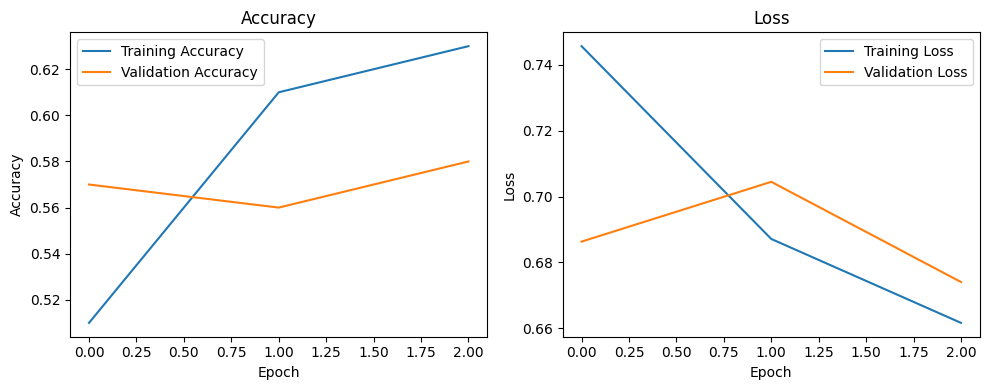

1/1 [==============================] - 2s 2s/step


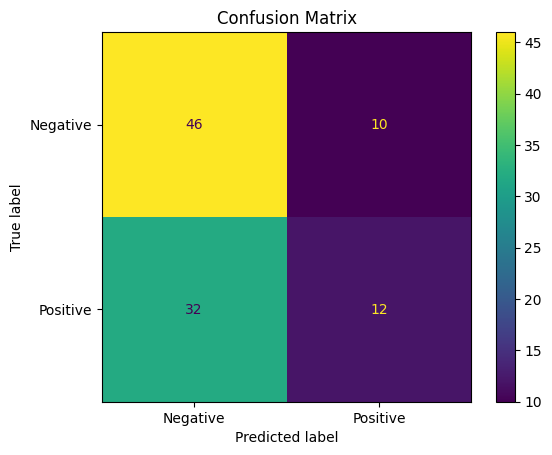


✅ Classification Report:

              precision    recall  f1-score   support

    Negative       0.59      0.82      0.69        56
    Positive       0.55      0.27      0.36        44

    accuracy                           0.58       100
   macro avg       0.57      0.55      0.53       100
weighted avg       0.57      0.58      0.54       100



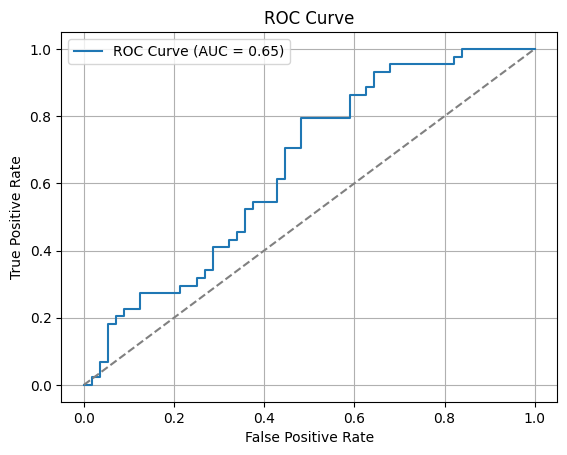

In [4]:
# ✅ Install required libraries (uncomment if needed)
# !pip install tensorflow tensorflow-hub tensorflow-text tensorflow-datasets matplotlib scikit-learn

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc

# ✅ Load a SMALL subset of the IMDB dataset
(train_data_full, test_data_full), info = tfds.load(
    'imdb_reviews',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

# ✅ Take smaller samples for faster training
train_data = train_data_full.take(200)
test_data = test_data_full.take(100)

# ✅ Load BERT preprocessing and encoder models
bert_preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

bert_preprocess = hub.KerasLayer(bert_preprocess_url, name="bert_preprocessing")
bert_encoder = hub.KerasLayer(bert_encoder_url, trainable=False, name="bert_encoder")

# ✅ Build the BERT-based classification model
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
bert_output = bert_encoder(preprocessed_text)['pooled_output']
dense = tf.keras.layers.Dense(128, activation='relu')(bert_output)
dropout = tf.keras.layers.Dropout(0.3)(dense)
final_output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout)

model = tf.keras.Model(inputs=text_input, outputs=final_output)

# ✅ Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# ✅ Prepare batched datasets
BATCH_SIZE = 8
train_ds = train_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# ✅ Train for just 3 epochs
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3
)

# ✅ Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {accuracy:.4f}")

# ✅ Plot training history
history_dict = history.history
plt.figure(figsize=(10, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ✅ Make predictions
y_true = []
y_pred = []
y_prob = []

for x_batch, y_batch in test_ds:
    preds = model.predict(x_batch)
    y_prob += preds.flatten().tolist()
    y_pred += (preds > 0.5).astype("int").flatten().tolist()
    y_true += y_batch.numpy().tolist()

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"]).plot()
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# ✅ Classification Report
print("\n✅ Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

# ✅ ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()
